In [2]:
import pandas as pd
from nlpia.data.loaders import get_data
pd.options.display.width = 120
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1500})

/srv/conda/envs/notebook/lib/python3.7/site-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/srv/conda/envs/notebook/lib/python3.7/site-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
/srv/conda/envs/notebook/lib/python3.7/site-packages/pugnlp/tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
/srv/conda/envs/notebook/lib/python3.7/site-packages/pugnlp/util.py:80: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
 

In [3]:
sms = get_data('sms-spam')

In [51]:
sms

spam                                                    text
0        0  Go until jurong point, crazy.. Available only in bu...
1        0                           Ok lar... Joking wif u oni...
2        1  Free entry in 2 a wkly comp to win FA Cup final tkt...
3        0       U dun say so early hor... U c already then say...
4        0  Nah I don't think he goes to usf, he lives around h...
...    ...                                                     ...
4832     1  This is the 2nd time we have tried 2 contact u. U h...
4833     0                    Will ü b going to esplanade fr home?
4834     0  Pity, * was in mood for that. So...any other sugges...
4835     0  The guy did some bitching but I acted like i'd be i...
4836     0                              Rofl. Its true to its name

[4837 rows x 2 columns]

limit_output extension: Maximum message size of 1500 exceeded with 1705 characters

In [52]:
index = ['sms{:=04d}{}'.format(i, '!'*j) for i,j in zip(range(len(sms)), sms.spam)]
index[:10]

['sms0000',
 'sms0001',
 'sms0002!',
 'sms0003',
 'sms0004',
 'sms0005!',
 'sms0006',
 'sms0007',
 'sms0008!',
 'sms0009!']

In [53]:
sms = pd.DataFrame(sms.values, columns=sms.columns, index=index)
sms['spam'] = sms.spam.astype(int)
print(len(sms))
sms.head(6)

4837


,spam,text
sms0000,0,"Go until jurong point, crazy.. Available only in bu..."
sms0001,0,Ok lar... Joking wif u oni...
sms0002!,1,Free entry in 2 a wkly comp to win FA Cup final tkt...
sms0003,0,U dun say so early hor... U c already then say...
sms0004,0,"Nah I don't think he goes to usf, he lives around h..."
sms0005!,1,FreeMsg Hey there darling it's been 3 week's now an...


In [54]:
sms.spam.sum()

638

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize
tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf_model.fit_transform(\
    raw_documents=sms.text).toarray()
tfidf_docs.shape
# num of words > num of messages, i.e. vocab >> labeled data

(4837, 9232)

In [56]:
mask = sms.spam.astype(bool).values
spam_centroid = tfidf_docs[mask].mean(axis=0)
ham_centroid = tfidf_docs[~mask].mean(axis=0)

print(\
spam_centroid.round(2),"\n",\
ham_centroid.round(2)\
)

[0.06 0.   0.   ... 0.   0.   0.  ] 
 [0.02 0.01 0.   ... 0.   0.   0.  ]


In [57]:
centroid_difference = spam_centroid - ham_centroid
spamminess_score = tfidf_docs.dot(centroid_difference)
print(tfidf_docs.shape, centroid_difference.shape, spamminess_score.shape)
spamminess_score.round(2)

(4837, 9232) (9232,) (4837,)


array([-0.01, -0.02,  0.04, ..., -0.01, -0.  ,  0.  ])

In [58]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

<AxesSubplot:ylabel='Density'>

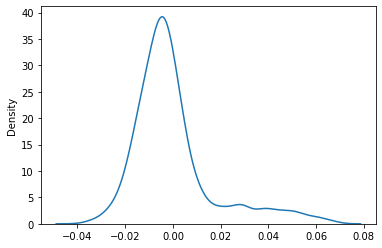

In [59]:
seaborn.kdeplot(spamminess_score) 

<AxesSubplot:ylabel='Density'>

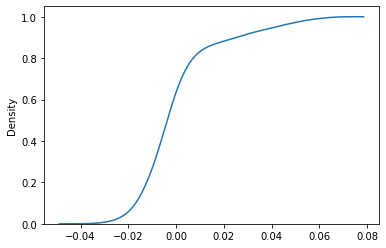

In [60]:
seaborn.kdeplot(spamminess_score, cumulative=True) 
# middle 50% is around -0.005

In [61]:
from sklearn.preprocessing import MinMaxScaler
sms['lda_score'] = MinMaxScaler().fit_transform(\
    spamminess_score.reshape(-1,1)) # reshape 1d to 2d, then scale from -1 to 1
sms['lda_predict'] = (sms.lda_score > .5).astype(int)
sms['spam lda_predict lda_score'.split()].round(2).head(6)

,spam,lda_predict,lda_score
sms0000,0,0,0.23
sms0001,0,0,0.18
sms0002!,1,1,0.72
sms0003,0,0,0.18
sms0004,0,0,0.29
sms0005!,1,1,0.55


In [62]:
from pugnlp.stats import Confusion

In [63]:
Confusion(sms['spam lda_predict'.split()])

/srv/conda/envs/notebook/lib/python3.7/site-packages/pugnlp/stats.py:504: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.__setattr__('_hist_labels', self.sum().astype(int))
/srv/conda/envs/notebook/lib/python3.7/site-packages/pugnlp/stats.py:510: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  setattr(self, '_hist_classes', self.T.sum())


lda_predict,0,1
spam,,
0,4135,64
1,45,593


In [64]:
from nlpia.book.examples.ch04_catdog_lsa_3x6x16 import word_topic_vectors

In [65]:
word_topic_vectors.T.round(1)

,cat,dog,apple,lion,nyc,love
top0,-0.6,-0.4,0.5,-0.3,0.4,-0.1
top1,-0.1,-0.3,-0.4,-0.1,0.1,0.8
top2,-0.3,0.8,-0.1,-0.5,0.0,0.1


In [66]:
from nlpia.book.examples.ch04_catdog_lsa_sorted\
    import lsa_models, prettify_tdm

In [67]:
bow_svd, tfidf_svd = lsa_models()

100%|██████████| 263/263 [00:00<00:00, 145221.43it/s]


In [68]:
prettify_tdm(**bow_svd)

cat dog apple lion nyc love                                             text
0              1        1                                 NYC is the Big Apple.
1              1        1                        NYC is known as the Big Apple.
2                       1    1                                      I love NYC!
3              1        1           I wore a hat to the Big Apple party in NYC.
4              1        1                       Come to NYC. See the Big Apple!
5              1                             Manhattan is called the Big Apple.
6    1                                  New York is a big city for a small cat.
7    1              1           The lion, a big cat, is the king of the jungle.
8    1                       1                               I love my pet cat.
9                       1    1                      I love New York City (NYC).
10   1   1                                              Your dog chased my cat.

limit_output extension: Maximum message size of 1500 exceeded with 2502 characters

In [69]:
tdm = bow_svd['tdm']
tdm

0   1   2   3   4   5   6   7   8   9   10
cat     0   0   0   0   0   0   1   1   1   0   1
dog     0   0   0   0   0   0   0   0   0   0   1
apple   1   1   0   1   1   1   0   0   0   0   0
lion    0   0   0   0   0   0   0   1   0   0   0
nyc     1   1   1   1   1   0   0   0   0   1   0
love    0   0   1   0   0   0   0   0   1   1   0

limit_output extension: Maximum message size of 1500 exceeded with 1933 characters

In [70]:
U, s, Vt = np.linalg.svd(tdm)

In [71]:
pd.DataFrame(U, index=tdm.index).round(2) # row eigenvectors, most important

,0,1,2,3,4,5
cat,-0.04,0.83,-0.38,-0.00,0.11,-0.38
dog,-0.00,0.21,-0.18,-0.71,-0.39,0.52
apple,-0.62,-0.21,-0.51,0.00,0.49,0.27
lion,-0.00,0.21,-0.18,0.71,-0.39,0.52
nyc,-0.75,0.00,0.24,-0.00,-0.52,-0.32
love,-0.22,0.42,0.69,0.00,0.41,0.37


In [72]:
s.round(1) # eigenvalues

array([3.1, 2.2, 1.8, 1. , 0.8, 0.5])

In [73]:
S = np.zeros((len(U), len(Vt)))
pd.np.fill_diagonal(S, s)
pd.DataFrame(S).round(1)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


,0,1,2,3,4,5,6,7,8,9,10
0,3.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


limit_output extension: Maximum message size of 1500 exceeded with 2263 characters

In [74]:
pd.DataFrame(Vt).round(2) # right eigenvectors

0     1     2     3     4     5     6     7     8     9     10
0  -0.44 -0.44 -0.31 -0.44 -0.44 -0.20 -0.01 -0.01 -0.08 -0.31 -0.01
1  -0.09 -0.09  0.19 -0.09 -0.09 -0.09  0.37  0.47  0.56  0.19  0.47
2  -0.16 -0.16  0.52 -0.16 -0.16 -0.29 -0.22 -0.32  0.17  0.52 -0.32
3   0.00 -0.00 -0.00  0.00  0.00  0.00 -0.00  0.71 -0.00 -0.00 -0.71
4  -0.04 -0.04 -0.14 -0.04 -0.04  0.58  0.13 -0.33  0.62 -0.14 -0.33
5  -0.09 -0.09  0.10 -0.09 -0.09  0.51 -0.73  0.27 -0.01  0.10  0.27
6  -0.57  0.21  0.11  0.33 -0.31  0.34  0.34  0.00 -0.34  0.23  0.00
7  -0.32  0.47  0.25 -0.63  0.41  0.07  0.07  0.00 -0.07 -0.18  0.00
8  -0.50  0.29 -0.20  0.41  0.16 -0.37 -0.37 -0.00  0.37 -0.17  0.00
9  -0.15 -0.15 -0.59 -0.15  0.42  0.04  0.04 -0.00 -0.04  0.63 -0.00
10 -0.26 -0.62  0.33  0.24  0.54  0.09  0.09  0.00 -0.09 -0.23 -0.00

limit_output extension: Maximum message size of 1500 exceeded with 3465 characters

In [75]:
err = []
for numdim in range(len(s), 0, -1):
    S[numdim - 1, numdim - 1] = 0
    reconstructed_tdm = U.dot(S).dot(Vt)
    err.append(np.sqrt(((\
        reconstructed_tdm - tdm).values.flatten() ** 2).sum()
        / np.product(tdm.shape)))
np.array(err).round(2)

array([0.06, 0.12, 0.17, 0.28, 0.39, 0.55])

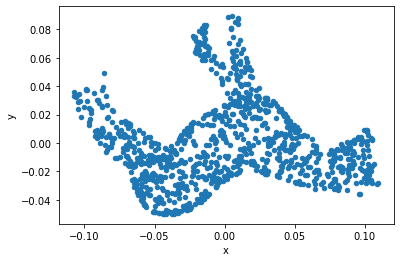

In [77]:
import pandas as pd
pd.set_option('display.max_columns', 6)
from sklearn.decomposition import PCA
import seaborn
from matplotlib import pyplot as plt
from nlpia.data.loaders import get_data
 
df = get_data('pointcloud').sample(1000)
pca = PCA(n_components=2)
df2d = pd.DataFrame(pca.fit_transform(df), columns=list('xy'))
df2d.plot(kind='scatter', x='x', y='y')
plt.show()



In [78]:
sms.head()

,spam,text,lda_score,lda_predict
sms0000,0,"Go until jurong point, crazy.. Available only in bu...",0.227478,0
sms0001,0,Ok lar... Joking wif u oni...,0.177888,0
sms0002!,1,Free entry in 2 a wkly comp to win FA Cup final tkt...,0.718785,1
sms0003,0,U dun say so early hor... U c already then say...,0.184565,0
sms0004,0,"Nah I don't think he goes to usf, he lives around h...",0.286944,0


In [81]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=sms.text).toarray()
len(tfidf.vocabulary_)

9232

In [83]:
tfidf_docs = pd.DataFrame(tfidf_docs)
tfidf_docs = tfidf_docs - tfidf_docs.mean()
tfidf_docs.shape

(4837, 9232)

In [84]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components=16)
pca = pca.fit(tfidf_docs)
pca_topic_vectors = pca.transform(tfidf_docs)
columns = ['topic{}'.format(i) for i in range(pca.n_components)]
pca_topic_vectors = pd.DataFrame(pca_topic_vectors, columns=columns,\
    index=index)
pca_topic_vectors.round(3).head(6)

,topic0,topic1,topic2,...,topic13,topic14,topic15
sms0000,0.201,0.003,0.037,...,-0.038,-0.014,0.033
sms0001,0.404,-0.094,-0.078,...,0.004,0.066,-0.024
sms0002!,-0.030,-0.048,0.090,...,-0.020,-0.039,0.045
sms0003,0.329,-0.033,-0.035,...,-0.023,0.057,-0.060
sms0004,0.002,0.031,0.038,...,0.023,-0.079,-0.023


limit_output extension: Maximum message size of 1500 exceeded with 1714 characters

In [85]:
pca_topic_vectors.shape

(4837, 16)

In [86]:
tfidf.vocabulary_

{'go': 3807,
 'until': 8487,
 'jurong': 4675,
 'point': 6296,
 ',': 13,
 'crazy': 2549,
 '..': 21,
 'available': 1531,
 'only': 5910,
 'in': 4396,
 'bugis': 1973,
 'n': 5594,
 'great': 3894,
 'world': 8977,
 'la': 4811,
 'e': 3056,
 'buffet': 1971,
 '...': 25,
 'cine': 2277,
 'there': 8071,
 'got': 3855,
 'amore': 1296,
 'wat': 8736,
 'ok': 5874,
 'lar': 4848,
 'joking': 4642,
 'wif': 8875,
 'u': 8395,
 'oni': 5906,
 'free': 3604,
 'entry': 3195,
 '2': 471,
 'a': 1054,
 'wkly': 8933,
 'comp': 2386,
 'to': 8192,
 'win': 8890,
 'fa': 3328,
 'cup': 2608,
 'final': 3450,
 'tkts': 8180,
 '21st': 497,
 'may': 5272,
 '2005': 487,
 '.': 15,
 'text': 8020,
 '87121': 948,
 'receive': 6688,
 'question': 6574,
 '(': 9,
 'std': 7651,
 'txt': 8379,
 'rate': 6628,
 ')': 10,
 't': 7889,
 '&': 7,
 "c's": 2020,
 'apply': 1383,
 '08452810075': 115,
 'over': 6003,
 '18': 438,
 "'": 8,
 's': 6959,
 'dun': 3041,
 'say': 7034,
 'so': 7438,
 'early': 3069,
 'hor': 4207,
 'c': 2019,
 'already': 1268,
 'then': 

limit_output extension: Maximum message size of 1500 exceeded with 15941 characters

In [90]:
column_nums, terms = zip(*sorted(zip(tfidf.vocabulary_.values(),\
    tfidf.vocabulary_.keys())))
terms

('!',
 '"',
 '#',
 '#150',
 '#5000',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '. .',
 '. . .',
 '. . . .',
 '. . . . .',
 '. ..',
 '..',
 '.. .',
 '.. . . .',
 '.. ... ...',
 '...',
 '... . . . .',
 '/',
 '0',
 '00',
 '00870405040',
 '0089',
 '01',
 '0121 2025050',
 '01223585236',
 '01223585334',
 '01256987',
 '02',
 '02/06',
 '02/09',
 '0207 153 9153',
 '0207 153 9996',
 '0207-083-6089',
 '02072069400',
 '02073162414',
 '02085076972',
 '03',
 '03530150',
 '04',
 '04/09',
 '05',
 '050703',
 '06',
 '06.05',
 '06/11',
 '07/11',
 '07008009200',
 '07046744435',
 '07090201529',
 '07090298926',
 '07099833605',
 '07123456789',
 '07732584351',
 '07734396839',
 '07742676969',
 '07753741225',
 '0776xxxxxxx',
 '07786200117',
 '077xxx',
 '078',
 '07801543489',
 '07808',
 '07808247860',
 '07808726822',
 '07815296484',
 '07821230901',
 '078498',
 '07880867867',
 '0789xxxxxxx',
 '07946746291',
 '0796xxxxxx',
 '07973788240',
 '07xxxxxxxxx',
 '08',
 '0800',
 '0800 0721072',
 '

limit_output extension: Maximum message size of 1500 exceeded with 11570 characters

In [91]:
weights = pd.DataFrame(pca.components_, columns=terms,
 index=['topic{}'.format(i) for i in range(16)])
pd.options.display.max_columns = 8
weights.head(4).round(3)

,!,"""",#,#150,...,…,┾,〨ud,鈥
topic0,-0.071,0.008,-0.001,-0.000,...,-0.002,0.001,0.001,0.001
topic1,0.064,0.008,0.000,-0.000,...,0.003,0.001,0.001,0.001
topic2,0.071,0.027,0.000,0.001,...,0.002,-0.001,-0.001,-0.001
topic3,-0.059,-0.032,-0.001,-0.000,...,0.001,0.001,0.001,0.001


limit_output extension: Maximum message size of 1500 exceeded with 1504 characters

In [95]:
pd.options.display.max_columns = 12
deals = weights['! ;) :) half off free crazy deal only $ 80 %'.split()]\
        .round(3) * 100
deals

!   ;)    :)  half  off  free  crazy  deal  only    $   80    %
topic0   -7.1  0.1  -0.5  -0.0 -0.4  -2.0   -0.0  -0.1  -2.2  0.3 -0.0 -0.0
topic1    6.4  0.0   7.4   0.1  0.4  -2.3   -0.2  -0.1  -3.8 -0.1 -0.0 -0.2
topic2    7.1  0.2  -0.1   0.0  0.3   4.4    0.1  -0.1   0.7  0.0  0.0  0.1
topic3   -5.9 -0.3  -7.1   0.2  0.3  -0.2    0.0   0.1  -2.3  0.1 -0.1 -0.3
topic4   38.1 -0.1 -12.5  -0.1 -0.2   9.8    0.1  -0.2   3.0  0.3  0.1 -0.1
topic5  -26.5  0.1  -1.6  -0.3 -0.7  -1.4   -0.6  -0.2  -1.8 -0.9  0.0  0.0
topic6  -10.9 -0.5  19.8  -0.4 -0.9  -0.6   -0.2  -0.1  -1.4 -0.0 -0.0 -0.1
topic7   15.8  0.1 -17.7   0.7  0.9  -3.0    0.0   0.1  -1.9 -0.3  0.0 -0.1
topic8   34.3  0.1   4.4  -0.5 -0.5  -0.1   -0.4  -0.4   3.2 -0.6 -0.0 -0.2
topic9    7.3 -0.3  16.2   1.4 -0.9   6.3   -0.5  -0.4   3.0 -0.4 -0.0  0.0
topic10 -31.9 -0.2  -8.8   0.1  0.1  12.5    0.1   0.0   0.2 -0.0 -0.1 -0.2
topic11 -22.2 -0.4 -28.3  -0.5 -1.4   4.9   -0.1  -0.1  -0.4  0.4  0.0  0.3
topic12  28.0  0.1 -27.3   0.0 -0.1   4.4    0.5  -0.0  -3.7 -0.3  0.0 -0.2
topic13   5.1 -0.3  39.8  -0.2  0.4   6.0    0.4   0.1  -0.1 -0.3  0.1 -0.3
topic14  -5.9  0.2   5.1  -0.3 -0.5   4.0    0.0  -0.3   3.4  0.4  0.0  0.0
topic15  -9.9 -0.4   2.6   0.0 -1.4  -1.8   -0.8   0.4   2.6 -0.5  0.1 -0.2

limit_output extension: Maximum message size of 1500 exceeded with 5049 characters

In [96]:
deals.T.sum()

topic0    -11.9
topic1      7.6
topic2     12.7
topic3    -15.5
topic4     38.2
topic5    -33.9
topic6      4.7
topic7     -5.4
topic8     39.3
topic9     31.7
topic10   -28.2
topic11   -47.8
topic12     1.4
topic13    50.7
topic14     6.1
topic15    -9.3
dtype: float64

In [97]:
from sklearn.decomposition import TruncatedSVD
 
svd = TruncatedSVD(n_components=16, n_iter=100)
svd_topic_vectors = svd.fit_transform(tfidf_docs.values)
svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns,\
    index=index)
svd_topic_vectors.round(3).head(6)

topic0  topic1  topic2  topic3  topic4  topic5  ...  topic10  topic11  topic12  topic13  topic14  topic15
sms0000    0.201   0.003   0.037   0.011  -0.019  -0.053  ...    0.007   -0.007    0.002   -0.036   -0.014    0.037
sms0001    0.404  -0.094  -0.078   0.051   0.100   0.047  ...   -0.004    0.036    0.043   -0.021    0.051   -0.042
sms0002!  -0.030  -0.048   0.090  -0.067   0.091  -0.043  ...    0.125    0.023    0.026   -0.020   -0.042    0.052
sms0003    0.329  -0.033  -0.035  -0.016   0.052   0.056  ...    0.022    0.023    0.073   -0.046    0.022   -0.070
sms0004    0.002   0.031   0.038   0.034  -0.075  -0.093  ...    0.028   -0.009    0.027    0.034   -0.083   -0.021
sms0005!  -0.016   0.059   0.014  -0.006   0.122  -0.040  ...    0.041    0.055   -0.037    0.075   -0.001    0.020

[6 rows x 16 columns]

limit_output extension: Maximum message size of 1500 exceeded with 2618 characters

In [98]:
import numpy as np
 
svd_topic_vectors = (svd_topic_vectors.T / np.linalg.norm(\
    svd_topic_vectors, axis=1)).T
svd_topic_vectors.iloc[:10].dot(svd_topic_vectors.iloc[:10].T).round(1)

sms0000  sms0001  sms0002!  sms0003  sms0004  sms0005!  sms0006  sms0007  sms0008!  sms0009!
sms0000       1.0      0.6      -0.1      0.6     -0.0      -0.3     -0.3     -0.1      -0.3      -0.3
sms0001       0.6      1.0      -0.2      0.8     -0.2       0.0     -0.2     -0.2      -0.1      -0.1
sms0002!     -0.1     -0.2       1.0     -0.2      0.1       0.4      0.0      0.3       0.5       0.4
sms0003       0.6      0.8      -0.2      1.0     -0.2      -0.3     -0.1     -0.3      -0.2      -0.1
sms0004      -0.0     -0.2       0.1     -0.2      1.0       0.2      0.0      0.1      -0.4      -0.2
sms0005!     -0.3      0.0       0.4     -0.3      0.2       1.0     -0.1      0.1       0.3       0.4
sms0006      -0.3     -0.2       0.0     -0.1      0.0      -0.1      1.0      0.1      -0.2      -0.2
sms0007      -0.1     -0.2       0.3     -0.3      0.1       0.1      0.1      1.0       0.1       0.4
sms0008!     -0.3     -0.1       0.5     -0.2     -0.4       0.3     -0.2      0.1       1.0       0.3
sms0009!     -0.3     -0.1       0.4     -0.1     -0.2       0.4     -0.2      0.4       0.3       1.0

limit_output extension: Maximum message size of 1500 exceeded with 2999 characters

In [99]:
total_corpus_len = 0
for document_text in sms.text:
    total_corpus_len += len(casual_tokenize(document_text))
mean_document_len = total_corpus_len / len(sms)
round(mean_document_len, 2)

21.35

In [100]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import casual_tokenize
np.random.seed(42)
 
counter = CountVectorizer(tokenizer=casual_tokenize)
bow_docs = pd.DataFrame(counter.fit_transform(raw_documents=sms.text)\
    .toarray(), index=index)
column_nums, terms = zip(*sorted(zip(counter.vocabulary_.values(),\
    counter.vocabulary_.keys())))
bow_docs.columns = terms

In [109]:
sms.loc['sms0000'].text

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [110]:
bow_docs.loc['sms0000'][bow_docs.loc['sms0000'] > 0].head()

,            1
..           1
...          2
amore        1
available    1
Name: sms0000, dtype: int64

In [6]:
from sklearn.decomposition import LatentDirichletAllocation as LDiA
 
ldia = LDiA(n_components=16, learning_method='batch')
ldia = ldia.fit(bow_docs)
ldia.components_.shape

NameError: name 'bow_docs' is not defined

In [112]:
pd.set_option('display.width', 75)
components = pd.DataFrame(ldia.components_.T, index=terms,\
    columns=columns)
components.round(2).head(3)

topic0  topic1  topic2  topic3  topic4  topic5  ...  topic10  topic11  \
!  184.03   15.00   72.22  394.95   45.48   36.14  ...    37.42    44.18   
"    0.68    4.22    2.41    0.06  152.35    0.06  ...     8.42    11.42   
#    0.06    0.06    0.06    0.06    0.06    2.07  ...     0.06     0.06   

   topic12  topic13  topic14  topic15  
!    64.40   297.29    41.16    11.70  
"     0.07    62.72    12.27     0.06  
#     1.07     4.05     0.06     0.06  

[3 rows x 16 columns]

limit_output extension: Maximum message size of 1500 exceeded with 1612 characters

In [113]:
components.topic3.sort_values(ascending=False)[:10]

!       394.952246
.       218.049724
to      119.533134
u       118.857546
call    111.948541
£       107.358914
,        96.954384
*        90.314783
your     90.215961
is       75.750037
Name: topic3, dtype: float64

In [114]:
ldia16_topic_vectors = ldia.transform(bow_docs)
ldia16_topic_vectors = pd.DataFrame(ldia16_topic_vectors,\
    index=index, columns=columns)
ldia16_topic_vectors.round(2).head()

topic0  topic1  topic2  topic3  topic4  topic5  ...  topic10  \
sms0000     0.00    0.62    0.00    0.00    0.00    0.00  ...     0.00   
sms0001     0.01    0.01    0.01    0.01    0.01    0.01  ...     0.01   
sms0002!    0.00    0.00    0.00    0.00    0.00    0.00  ...     0.00   
sms0003     0.00    0.00    0.00    0.00    0.09    0.00  ...     0.00   
sms0004     0.39    0.00    0.33    0.00    0.00    0.00  ...     0.00   

          topic11  topic12  topic13  topic14  topic15  
sms0000      0.00     0.00     0.00     0.00     0.00  
sms0001      0.12     0.01     0.01     0.01     0.01  
sms0002!     0.00     0.00     0.00     0.00     0.00  
sms0003      0.00     0.00     0.00     0.00     0.00  
sms0004      0.00     0.09     0.00     0.00     0.00  

[5 rows x 16 columns]

limit_output extension: Maximum message size of 1500 exceeded with 2213 characters

In [118]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =\
 train_test_split(ldia16_topic_vectors, sms.spam, test_size=0.5,\
 random_state=271828)
lda = LDA(n_components=1)
lda = lda.fit(X_train, y_train)
sms['ldia16_spam'] = lda.predict(ldia16_topic_vectors)
round(float(lda.score(X_test, y_test)), 2)

0.94

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis\
    import LinearDiscriminantAnalysis as LDA

tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=sms.text).toarray()
tfidf_docs = tfidf_docs - tfidf_docs.mean(axis=0) 
 
X_train, X_test, y_train, y_test = train_test_split(tfidf_docs,\
    sms.spam.values, test_size=0.5, random_state=271828)
lda = LDA(n_components=1)
lda = lda.fit(X_train, y_train)
print(round(float(lda.score(X_train, y_train)), 3))
round(float(lda.score(X_test, y_test)), 3)
# this cell uses a lot of memory

In [8]:
LDA??